

Umut Caliskan - U254835

Murat Kacmaz - U254799

# LoFTR demo with custom image pairs on Colab
We provide an easier way to run LoFTR with a custom image pair without configuring a python environment with GPU support. Signing in your Google account is required to run this notebook in Colab.

Start by clicking Runtime --> Run all (Ctrl/Cmd + F9).

Upload your own image pair with the "Choose Files" button to appear in the first cell. Please use horizontal images (width > height) and assign the image type (indoor/outdoor) accordingly.

In [ ]:
print("Please wait for ~8 seconds for the GPU session initialization. \n \
==> Please select both images at the same time after clicking \"Choose Files\".")
!mkdir -p /content/uploaded/ && rm -rf /content/uploaded/* # clear previously uploaded images
%cd /content/uploaded/
from google.colab import files
uploaded = files.upload()

for file_name in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=file_name, length=len(uploaded[file_name])))
image_pair = ['/content/uploaded/' + f for f in list(uploaded.keys())]
%cd ..

# Change the image type here.
#image_type = 'indoor'
image_type = 'outdoor'

Please wait for ~8 seconds for the GPU session initialization. 
 ==> Please select both images at the same time after clicking "Choose Files".
/content/uploaded


Saving IMG_20241217_095519.jpg to IMG_20241217_095519.jpg
Saving IMG_20241217_095523.jpg to IMG_20241217_095523.jpg
User uploaded file "IMG_20241217_095519.jpg" with length 12019880 bytes
User uploaded file "IMG_20241217_095523.jpg" with length 12235050 bytes
/content


You can also choose to use the example image pair provided in the LoFTR repo (from ScanNet) by using this cell (uncommenting the last line).


In [ ]:
img0_pth = "/content/uploaded/IMG_20241217_095519.jpg"
img1_pth = "/content/uploaded/IMG_20241217_095523.jpg"
image_pair = [img0_pth, img1_pth]
image_pair = [img1_pth, img0_pth]

In [ ]:
# Configure environment and grab LoFTR code.
!rm -rf sample_data
!pip install torch einops yacs kornia
!git clone https://github.com/zju3dv/LoFTR --depth 1
!mv LoFTR/* . && rm -rf LoFTR

# Download pretrained weights
!mkdir weights
%cd weights/
#!gdown --id 1w1Qhea3WLRMS81Vod_k5rxS_GNRgIi-O  # indoor-ds
!gdown --id 1M-VD35-qdB5Iw-AtbDBCKC7hPolFW9UY  # outdoor-ds
%cd ..

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 89.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
   

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.cm as cm

from src.utils.plotting import make_matching_figure
from src.loftr import LoFTR, default_cfg

In [ ]:
# The default config uses dual-softmax.
# The outdoor and indoor models share the same config.
# You can change the default values like thr and coarse_match_type.
matcher = LoFTR(config=default_cfg)
if image_type == 'indoor':
  matcher.load_state_dict(torch.load("weights/indoor_ds.ckpt")['state_dict'])
elif image_type == 'outdoor':
  matcher.load_state_dict(torch.load("weights/outdoor_ds.ckpt")['state_dict'])
else:
  raise ValueError("Wrong image_type is given.")
matcher = matcher.eval().cuda()

In [ ]:
# Rerun this cell (and below) if a new image pair is uploaded.
img0_raw = cv2.imread(image_pair[0], cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(image_pair[1], cv2.IMREAD_GRAYSCALE)
img0_raw = cv2.resize(img0_raw, (640, 480))
img1_raw = cv2.resize(img1_raw, (640, 480))

img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
batch = {'image0': img0, 'image1': img1}

# Inference with LoFTR and get prediction
with torch.no_grad():
    matcher(batch)
    mkpts0 = batch['mkpts0_f'].cpu().numpy()
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf'].cpu().numpy()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

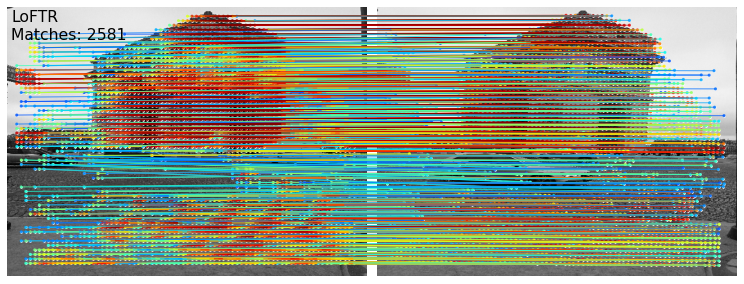

In [ ]:
# Draw
color = cm.jet(mconf, alpha=0.7)
text = [
    'LoFTR',
    'Matches: {}'.format(len(mkpts0)),
]
fig = make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, mkpts0, mkpts1, text)

# A high-res PDF will also be downloaded automatically.
make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, mkpts0, mkpts1, text, path="LoFTR-colab-demo.pdf")
files.download("LoFTR-colab-demo.pdf")

In [ ]:
img0_pth = "/content/uploaded/WhatsApp Image 2025-04-14 at 21.28.51 (1).jpeg"
img1_pth = "/content/uploaded/WhatsApp Image 2025-04-14 at 21.28.51.jpeg"
image_pair = [img0_pth, img1_pth]
image_pair = [img1_pth, img0_pth]

In [ ]:
# Rerun this cell (and below) if a new image pair is uploaded.
img0_raw = cv2.imread(image_pair[0], cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(image_pair[1], cv2.IMREAD_GRAYSCALE)
img0_raw = cv2.resize(img0_raw, (640, 480))
img1_raw = cv2.resize(img1_raw, (640, 480))

img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
batch = {'image0': img0, 'image1': img1}

# Inference with LoFTR and get prediction
with torch.no_grad():
    matcher(batch)
    mkpts0 = batch['mkpts0_f'].cpu().numpy()
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf'].cpu().numpy()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

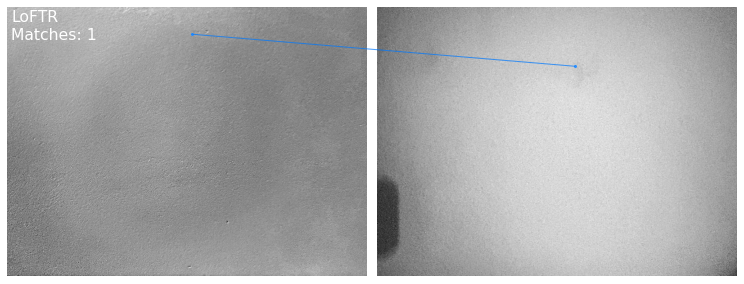

In [ ]:
# Draw
color = cm.jet(mconf, alpha=0.7)
text = [
    'LoFTR',
    'Matches: {}'.format(len(mkpts0)),
]
fig = make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, mkpts0, mkpts1, text)

# A high-res PDF will also be downloaded automatically.
make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, mkpts0, mkpts1, text, path="LoFTR-colab-demo1.pdf")
files.download("LoFTR-colab-demo1.pdf")

In [ ]:
img0_pth = "/content/uploaded/WhatsApp Image 2025-04-14 at 21.35.46 (1).jpeg"
img1_pth = "/content/uploaded/WhatsApp Image 2025-04-14 at 21.35.46.jpeg"
image_pair = [img0_pth, img1_pth]
image_pair = [img1_pth, img0_pth]

In [ ]:
# Rerun this cell (and below) if a new image pair is uploaded.
img0_raw = cv2.imread(image_pair[0], cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(image_pair[1], cv2.IMREAD_GRAYSCALE)
img0_raw = cv2.resize(img0_raw, (640, 480))
img1_raw = cv2.resize(img1_raw, (640, 480))

img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
batch = {'image0': img0, 'image1': img1}

# Inference with LoFTR and get prediction
with torch.no_grad():
    matcher(batch)
    mkpts0 = batch['mkpts0_f'].cpu().numpy()
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf'].cpu().numpy()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

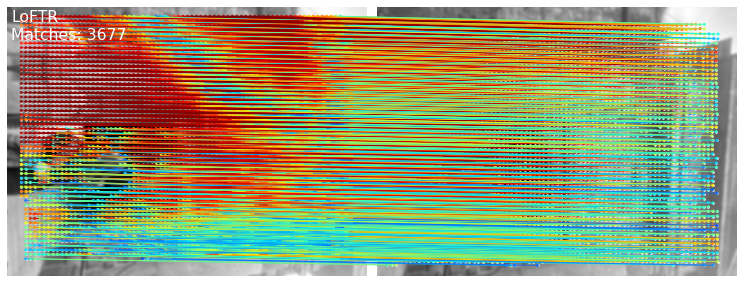

In [ ]:
# Draw
color = cm.jet(mconf, alpha=0.7)
text = [
    'LoFTR',
    'Matches: {}'.format(len(mkpts0)),
]
fig = make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, mkpts0, mkpts1, text)

# A high-res PDF will also be downloaded automatically.
make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, mkpts0, mkpts1, text, path="LoFTR-colab-demo2.pdf")
files.download("LoFTR-colab-demo2.pdf")

In [ ]:
img0_pth = "/content/uploaded/IMG_20241109_165634 (1).jpg"
img1_pth = "/content/uploaded/IMG_20241109_165648.jpg"
image_pair = [img0_pth, img1_pth]
image_pair = [img1_pth, img0_pth]

In [ ]:
# Rerun this cell (and below) if a new image pair is uploaded.
img0_raw = cv2.imread(image_pair[0], cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(image_pair[1], cv2.IMREAD_GRAYSCALE)
img0_raw = cv2.resize(img0_raw, (640, 480))
img1_raw = cv2.resize(img1_raw, (640, 480))

img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
batch = {'image0': img0, 'image1': img1}

# Inference with LoFTR and get prediction
with torch.no_grad():
    matcher(batch)
    mkpts0 = batch['mkpts0_f'].cpu().numpy()
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf'].cpu().numpy()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

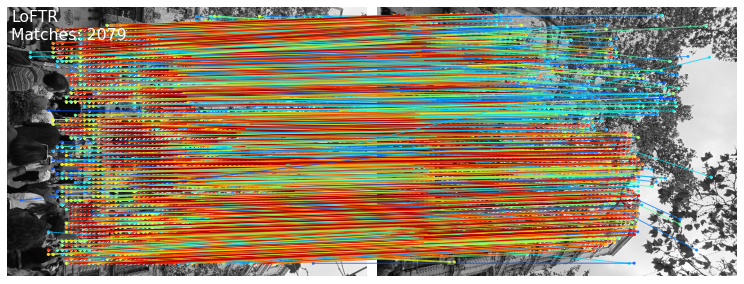

In [ ]:
# Draw
color = cm.jet(mconf, alpha=0.7)
text = [
    'LoFTR',
    'Matches: {}'.format(len(mkpts0)),
]
fig = make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, mkpts0, mkpts1, text)

# A high-res PDF will also be downloaded automatically.
make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, mkpts0, mkpts1, text, path="LoFTR-colab-demo3.pdf")
files.download("LoFTR-colab-demo3.pdf")